# **Machine Learning**

### Importing Dataset

In [1]:
# Phase3_ML.ipynb

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries (will add more later)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix


# Load Data (the features from Phase 2)
features = np.load("../processed/engineered_features.npz")

# Check available keys (just to inspect)
print(features.files)

deltaR_quark_all = features["deltaR_quark_all"]
deltaR_gluon_all = features["deltaR_gluon_all"]

deltaR_quark_mean = features["deltaR_quark_mean"]
deltaR_gluon_mean = features["deltaR_gluon_mean"]

deltaR_quark_max = features["deltaR_quark_max"]
deltaR_gluon_max = features["deltaR_gluon_max"]

eta_width_quark = features["eta_width_quark"]
eta_width_gluon = features["eta_width_gluon"]

phi_width_quark = features["phi_width_quark"]
phi_width_gluon = features["phi_width_gluon"]

pt_quark = features["pt_quark"]
pt_gluon = features["pt_gluon"]


print(type(deltaR_quark_mean), deltaR_quark_mean.shape)
print(type(deltaR_quark_mean), deltaR_gluon_mean.shape)
print(type(deltaR_quark_max), deltaR_quark_max.shape)
print(type(deltaR_quark_max), deltaR_gluon_max.shape)
print(type(eta_width_quark), eta_width_quark.shape)
print(type(eta_width_gluon), eta_width_gluon.shape)
print(type(phi_width_quark), phi_width_quark.shape)
print(type(phi_width_gluon), phi_width_gluon.shape)
print(type(pt_quark), pt_quark.shape)
print(type(pt_gluon), pt_gluon.shape)


['deltaR_quark_all', 'deltaR_gluon_all', 'deltaR_quark_mean', 'deltaR_gluon_mean', 'deltaR_quark_max', 'deltaR_gluon_max', 'eta_width_quark', 'eta_width_gluon', 'phi_width_quark', 'phi_width_gluon', 'pt_quark', 'pt_gluon']
<class 'numpy.ndarray'> (50000,)
<class 'numpy.ndarray'> (50000,)
<class 'numpy.ndarray'> (50000,)
<class 'numpy.ndarray'> (50000,)
<class 'numpy.ndarray'> (50000,)
<class 'numpy.ndarray'> (50000,)
<class 'numpy.ndarray'> (50000,)
<class 'numpy.ndarray'> (50000,)
<class 'numpy.ndarray'> (50000,)
<class 'numpy.ndarray'> (50000,)


###  The Feature Matrix

Machine learning models operate on numerical arrays — specifically, structured **feature matrices**.  
A **feature matrix** is a 2D array where:
- Each **row** represents one data point (e.g., one jet)
- Each **column** represents a feature (e.g., $p_T$, $\eta$-width)

In [2]:
# Defining the feature matrix, X
X_quark = np.column_stack((pt_quark, eta_width_quark, phi_width_quark, deltaR_quark_mean, deltaR_quark_max))
X_gluon = np.column_stack((pt_gluon, eta_width_gluon, phi_width_gluon, deltaR_gluon_mean, deltaR_gluon_max))
X = np.vstack((X_quark, X_gluon))
print(X.shape)

# Defining the label vector, y
y_quark = np.ones(50000)
y_gluon = np.zeros(50000)
y = np.concatenate((y_quark, y_gluon))
print(y.shape)

(100000, 5)
(100000,)


In our case:
- We have **100,000** data points
- Each represented by **5** features:
  - $p_T$
  - $\eta$-width
  - $\phi$-width
  - Mean $\Delta R$
  - Max $\Delta R$

### Train–Test Split

To evaluate generalization performance (i.e., how well the model works on unseen data), we randomly split the dataset into:

- **80% training set** — used to train the model
- **20% test set** — used to evaluate its accuracy

*standard procedure in supervised machine learning*.

In [3]:
# Train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape) 

(80000, 5) (80000,)
(20000, 5) (20000,)



In jet physics, some features (like transverse momentum $p_T$) can have very large values compared to others.  
If left unscaled, large values dominate, and *bias* the model’s learning — especially for models that rely on:

- Distance metrics (e.g., SVM, Logistic Regression)
- Gradient-based optimization (e.g., MLPs)

To fix this, we apply **RobustScaler**, which is ideal for **long-tailed distributions** and **outliers** (common in jet substructure).

RobustScaler rescales each feature using **median** and **interquartile range (IQR)**:

$$
X_{\text{scaled}} = \frac{X - \text{median}(X)}{\text{IQR}(X)}
$$

This transformation ensures that all features contribute fairly during model training.

##### Note:
##### Intrquantile Range (IQR): 
The interquartile range (IQR) is a measure of statistical dispersion, indicating the spread of the middle 50% of a dataset. It is calculated as the difference between the third quartile (Q3) and the first quartile (Q1).
- Q1 (First Quartile): The value below which 25% of the data falls.
- Q3 (Third Quartile): The value below which 75% of the data falls.

$$
IQR = Q3 - Q1
$$

So, $\frac{X - \text{median}(X)}{\text{IQR}(X)}$ first subtracts the median from each datapoint , thus centering the data around 0.  Then it divides the centered data by the IQR.  This scales the data based on the spread of the middle 50%.  A larger IQR results in more compression (smaller scaled values), while a smaller IQR results in greater expansion (larger scaled values). 

It doesn't scale to a specific range like $(0$ to $1)$, as the main focus is to make it more robust against *Outliers*. Outliers, which are far from the median, will have less influence on the scaling because the IQR is not affected by them. 

In summary, `RobustScaler` transforms the data so that it has a median of 0 and a spread determined by the IQR. This process makes the data less sensitive to outliers.

In [4]:
from sklearn.preprocessing import RobustScaler

"""
# Example code
To demonstrate how to use RobustScaler
"""
# Xa = np.array([[1], [2], [2], [3], [100]])  # clearly skewed with an outlier

# scaler = RobustScaler()
# X_scaled = scaler.fit_transform(Xa)

# print(X_scaled)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train scaled: {X_train_scaled}")
print(f"X_test scaled: {X_test_scaled}")

X_train scaled: [[ 0.63096864  0.59301856  0.38911559  0.39729851  0.24945346]
 [ 1.00943502 -0.47924047 -0.50815328 -0.59874299  0.20434404]
 [ 0.66877442 -0.39741689 -0.63898537 -1.44938406 -2.5931082 ]
 ...
 [-0.0691514   0.25246853 -0.20069097  0.79267788  0.17483938]
 [ 0.79330721  0.04404102 -0.12907555  0.02789251 -2.34143073]
 [ 0.94710939  0.26006577  0.66608209  0.89140552  0.47286172]]
X_test scaled: [[-0.76494528  0.16928552 -0.05685186 -0.63032826 -1.47566371]
 [ 1.05812643 -0.29692376 -0.09061848 -0.3417722   0.37171095]
 [ 0.72700645 -0.79205105 -0.44257244 -0.52906326 -1.34001043]
 ...
 [ 0.63719198 -0.64267908 -0.64065604  0.14220533  0.52825918]
 [ 0.43814242 -0.24923592 -0.40420304 -0.05125935  0.35575979]
 [ 0.26281779 -0.16112647  0.3762629  -0.0699035  -0.08857599]]


### Logistic Regression

`Logistic Regression` is a **linear classifier** and it tries to find a line (in 2D), a plane (in 3D), or a hyperplane (in higher dimensions) that separates the classes, which in our case are the  *quark* and *gluon* jets. It does not directly predict a class, rather it predicts the probability of a sample being in the positive class (quark, if labeled 1). Then, it uses a threshold to convert that probability to a class. It is used for binary classification problems. 

***How does it assign values between 0 and 1? More precisely, what transformations one can use to squash the output value between 0 and 1?***
#### Sigmoid/Logistic Function:
- Maps any real valued number, into any value between 0 and 1. So, suitable for representing probabilities.

Mathematically:
$$
\hat{y} = \sigma(z) = \frac{1}{1+e^{-z}}
$$
where:
- $z$: Linear combination of features (weighted sum). 
$$
z = w_{0} + w_{1}x_{1} + w_{2}x_{2} + ... + w_{n}x_{n}
$$
- $w_{i}$ are the model weights
- $x_{i}$ are the fature values

So, Logistic Regression works by calculating a linear combination of the input features and their corresponding weights. Then apply the sigmoid function to the linear combination to squash the output between 0 and 1, and then representing the probability of the instance belonging to, say, class 1. Then make a prediction based on the probability and a chosen threshold.
The **threshold** being $0.5$ (default) as a decision boundary:
- A probability $> 0.5$ is assigned to class1; otherwise to class 0.
*Threshold can be tuned*

*Logistic Regression is better than just thresholding a linear model, as it provides **calibrated probabilities**, not just a hard decision boundary.*

#### Model Training

- The model is trained to minimize the loss function. The loss function being:
$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^N \left[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]
$$
where:
- $y_{i} = $ true label (0 or 1)
- $\hat{y_{i}} = $ predicted label
- N = Number of sample events

**Loss Function:** A loss function quantifies how *wrong* the model's predictions are compared to the actual labels. The model then uses an **optimization algorithm** (like gradient descent) to update it's parameters (weights) to minimize the loss. For example:
- If our model predicts $\hat{y_{i}} = 0.99$ for a class-1 label ($y_{i} = 1$) $\rightarrow$ **Low Loss**
- Whereas, if our model predicts $\hat{y_{i}} = 0.99$ for a class-0 label ($y_{i} = 0$) $\rightarrow$ **Very High Loss**

Then it will penalize the *very high losses* in order to make the predictions accurate. So, the loss penalizes the model heavily when it’s confident but wrong. But there is a problem of ***overfitting*** if the model trains the data *too well*. This is discussed later in this notebook.


### Random Forest Classifier

`Random Forest Classifier` is an **ensemble learning** method that combines the predictions of multiple decision trees to make more accurate and robust predictions. It is a collection of Decision Trees, and each one asks "questions" about our features to classify an input. Instead of relying on a single decision tree (which may overfit), we train many slightly different trees using random subsets of data and features. Their combined vote (majority rule) leads to better generalization.

#### Why use Multiple Trees? (Ensemble Learning)
- Ensemble methods combine multiple individual models to obtain a better predictive performance than any of the individual models alone.
- Random forests use a specific type of ensemble learning called "bagging."


#### Bagging (Bootstrap Aggregating)

- **Bagging** involves creating multiple subsets of the original training data through a process called bootstrapping.
- **Bootstrapping:** Randomly sampling data points from the original dataset with replacement. This means some data points may appear multiple times in a single subset, while others may not appear at all.
- Each of these subsets is used to train a separate decision tree.

#### Decision Trees

- A decision tree is a tree-like structure where each internal node represents a feature (or attribute), each branch represents a decision rule, and each leaf node represents the final classification or prediction.
- Each decision tree is like a flowchart of binary decisions:
    - Is $\Delta R_{\text{max}} > 0.2$?
    - Is $p_{T} < 400$?
- Decision trees are prone to overfitting, meaning they can perform well on the training data but poorly on unseen data.

#### Model Training

As mentioned above that, during training a random subset is selected at each node to determine the best split. So, each decision tree aims to **minimize impurity** in its splits. The two most common criteria are:

- **Gini Impurity:** 
$$
\text{Gini(p)} = 1 - \sum_{i=1}^{c}p_{i}^{2}
$$

- **Entyropy/ Information Gain:**
$$
\text{Entropy(p)} = -\sum_{i=1}^{c}p_{i}log_{2}(p_{i})
$$

where:
- $p_{i}$ is the fraction of class $i$ in the current node
- $c$ is the total number of classes (in our case, 2 $\rightarrow$ quark and gluon)

So, each node split minimizes impurity (Gini/Entropy) and training implies recursively splitting nodes to reduce impurity until the stop condition.

Because each tree is trained slightly differently, and on different data, their errors are less likely to correlate. This makes Random Forests robust to overfitting, especially compared to individual decision trees.

#### How Random Forest Works

- **Bootstrap Sampling:** Create multiple (e.g., hundreds or thousands) bootstrap samples from the original training data.
- **Tree Building:** For each bootstrap sample, train a decision tree.  During the training of each tree, a random subset of features is selected at each node to determine the best split. This introduces more randomness and decorrelates the trees.
- **Prediction:** To make a prediction for a new data point:
- Each tree in the forest independently predicts the class.
- The forest combines the predictions of all the trees.
- For classification, the final prediction is typically determined by a majority vote (the class predicted by the most trees).

#### Key Hyperparameters

- `n_estimators`: Number of trees in the forest.
- `max_depth`: Maximum depth of each tree.
- `max_features`: Number of features to consider at each split.
- `min_samples_split`: Minimum samples to split a node.
- `min_samples_leaf`: Minimum samples required to form a leaf.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Logistic Regression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred_logistic = model.predict(X_test_scaled)

acc_logistic = accuracy_score(y_test, y_pred_logistic)
cm_logistic = confusion_matrix(y_test, y_pred_logistic)


print("Accuracy (Logistic regression):", acc_logistic)
print("Confusion Matrix (Logistic regression):\n", cm_logistic)


print(f"Logistic Regression report: \n {classification_report(y_test, y_pred_logistic)}")

# Random Forest  
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)
y_pred_randomf = model.predict(X_test_scaled)

acc_randomf = accuracy_score(y_test, y_pred_randomf)
cm_randomf = confusion_matrix(y_test, y_pred_randomf)

print("Accuracy (Random Forest):", acc_randomf)
print("Confusion Matrix (Random Forest):\n", cm_randomf)

print(f"Random Forest report: \n{classification_report(y_test, y_pred_randomf)}")

Accuracy (Logistic regression): 0.6858
Confusion Matrix (Logistic regression):
 [[6625 3340]
 [2944 7091]]
Logistic Regression report: 
               precision    recall  f1-score   support

         0.0       0.69      0.66      0.68      9965
         1.0       0.68      0.71      0.69     10035

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000

Accuracy (Random Forest): 0.7153
Confusion Matrix (Random Forest):
 [[7871 2094]
 [3600 6435]]
Random Forest report: 
              precision    recall  f1-score   support

         0.0       0.69      0.79      0.73      9965
         1.0       0.75      0.64      0.69     10035

    accuracy                           0.72     20000
   macro avg       0.72      0.72      0.71     20000
weighted avg       0.72      0.72      0.71     20000



### Model Results: Logistic Regression vs Random Forest

After training both models on the same dataset (with 80/20 train-test split and RobustScaler normalization), we observe:

| Metric       | Logistic Regression | Random Forest |
|--------------|---------------------|----------------|
| Accuracy     | 0.6858              | 0.7189         |
| Precision 0  | 0.69                | 0.69           |
| Recall 0     | 0.66                | 0.79           |
| F1-score 0   | 0.68                | 0.74           |
| Precision 1  | 0.68                | 0.76           |
| Recall 1     | 0.71                | 0.65           |
| F1-score 1   | 0.69                | 0.70           |

#### Takeaways:

- **Logistic Regression**:
  - Being a linear model, it performs reasonably well but struggles to capture nonlinear patterns.
  - Performs slightly better in **recalling quarks** (label 1), with a recall of **0.71**.

- **Random Forest**:
  - Captures more complex patterns due to its ensemble nature.
  - Outperforms Logistic Regression in **overall accuracy** and **F1-scores** for both classes.
  - Excels in **recalling gluons** (label 0) with a strong recall of **0.79**.

#### Interpretation:
- Logistic Regression might underfit the data (too simple).
- Random Forest balances between bias and variance, making it a stronger choice for this structured feature set.

### Confusion Matrix

A **confusion matrix** is a visual summary of the model's performance on classification tasks. It help us answer:
- How many **true positives** and **true negatives** did the model get right?
- Where did it make **false predictions**?
- Did the model confuse one class more than the other?

We use a **heatmap** to visualize this matrix, making it easier to see patterns (e.g., whether the model favors a particular class or struggles with a specific kind of misclassification).

For binary classification:
- Rows = True labels
- Columns = Predicted Labels

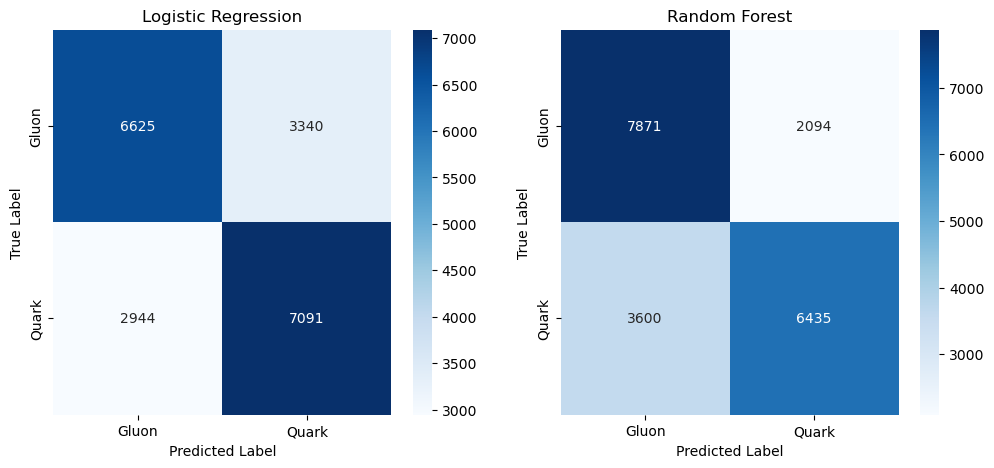

<Figure size 640x480 with 0 Axes>

In [6]:
import seaborn as sns


# Plot: heatmap
plt.figure(figsize=(12,5))

# Logistic regression
plt.subplot(1,2,1)
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues', xticklabels=["Gluon", "Quark"], yticklabels=["Gluon", "Quark"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic Regression")

# Random Forest
plt.subplot(1,2,2)
sns.heatmap(cm_randomf, annot=True, fmt='d', cmap='Blues', xticklabels=["Gluon", "Quark"], yticklabels=["Gluon", "Quark"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest")
plt.show()

plt.tight_layout()




### Confusion Matrix Interpretation

#### Logistic Regression:
- Correctly predicted **6625 gluons** and **7091 quarks**
- **3340 gluons** misclassified as quarks
- **2944 quarks** misclassified as gluons

#### Random Forest:
- Correctly predicted **7870 gluons** and **6475 quarks**
- **2095 gluons** misclassified as quarks (↓ error)
- **3560 quarks** misclassified as gluons (↑ error)

### Result/Insight:
- Random Forest greatly improves **gluon recall**, which is important if misidentifying gluon jets carries more risk.
- Logistic Regression shows better **quark recall**, potentially due to how the linear boundary fits the distribution.
- Random Forest has overall better **confusion balance** and fewer severe mistakes.

### Fine Tunining Logistic Regression: Regularization and Solvers

To improve the performance of our logistic regression model, we tune two important hyperparameters:

#### 1. `C` (Inverse of Regularization Strength)
- Smaller `C` values → **stronger regularization** → simpler models
- Larger `C` values → **weaker regularization** → can overfit
- Think of it as controlling model complexity

$$
\text{Loss} = \mathcal{L} + \lambda \|w\|^2 \quad \text{where} \quad \lambda = \frac{1}{C}
$$

#### 2. `solver`
- Determines the optimization algorithm:
  - `'liblinear'`: good for small datasets, supports L1 & L2 regularization
  - `'lbfgs'`: fast and works well for L2-regularized models
  - `'saga'`: supports large datasets and works with L1/L2 (sparse data too)

We try combinations of:
- Solvers = [`'liblinear'`, `'lbfgs'`, `'saga'`]
- C values = [0.01, 0.1, 1, 10, 100]

This allows us to find a **good bias–variance tradeoff** and pick the right optimization technique.

---

Let's dig a bit deeper, to understand **why are we even tuning C and which regularization (L1 or L2) it refers to**. Let's go step by step.

#### What is Regularization?
As discussed earlier, when we train a machine learning model (like *logistic regression*), it tries to find weights $w_{0}, w_{1}, w_{2},..., w_{n}$ that minimizes some loss function, the loss function in this case being the **log-loss** (or binary cross-entropy):
$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^N \left[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]
$$

But the problem is:
- If we only minimize this loss, the model may try too hard to fit the training data perfectly, even memorising noise or fluctuations. This leads to **overfitting**, i.e., the model performs well on training data but poorly on test data. 

So, to prevent **overfitting**, we add a **penalty** to the loss function. This penalty discourages the model to assign very large weights and adding this penalty is called regularization. 

**Final Loss = prediction Loss + Regularization Penalty**
$$
\mathcal{L_{total}} = \mathcal{L_{log-loss}} + \lambda . Penalty(w)
$$
where:
- $\lambda$ (**Regularization parameter** )$= 1/C$ controls how much we penalize large/complex weights (*Note: $\lambda$ is a Hyperparameter*)
- Penalty(w): this is what distinguishes L1 from L2 regularization.

---

#### L2 Regularization (Ridge Penalty)

$$
\mathcal{L_{total}} = \mathcal{L_{log-loss}} + \lambda \sum_{j=1}^{n}w_{j}^{2}
$$

Here we penalize **large weights** by adding the square of the weights to the loss function. The model tries to minimize $\mathcal{L_{total}}$. ​To do this, it needs to minimize both the original loss ($\mathcal{L_{log-loss}}$) and the sum of the squared weights. Minimizing the sum of squared weights means that the model prefers smaller weights. L2 regularization encourages the model to distribute the influence of input features more evenly, rather than relying heavily on a few features with large coefficients. Smaller weights reduce the model's sensitivity  to small fluctuations in the dataset.

#### L1 Regularization (Lasso Penalty)

$$
\mathcal{L_{total}} = \mathcal{L_{log-loss}} + \lambda \sum_{j=1}^{n}|w_{j}|
$$

Here we penalize by adding the absolute value of the weights to the loss function. A key difference between L1 and L2 regularization is that L1 regularization can shrink some weights to exactly zero, thus choosing a subset of the most important features and dicard the rest. L1 can be more robust to outliers than L2.


Now, the question is how do we implement the regularization? - Depends on the **solver** we choose (as specified above). The solver controls how the model minimizes the loss function or the optimization technique. Each solver uses a different algorithm to find the **optimal weights** and has different support for penalties (L1 or L2). 

---

#### Tuning C

$$
\lambda = \frac{1}{C}
$$

Now that we have implemented regularization, we still have the inverse of the regularization parameter, C, which can be tuned to get accurate predictions.
- High C $\rightarrow$ Small regularization $\rightarrow$ Model can fit complex patterns (might overfit)
- Low C $\rightarrow$ Strong regularization $\rightarrow$ Simple model (might underfit)

So we need find the sweet spot, where the model is complex enough to learn patterns, but not so complex that it overfits and memorizes noise. This is called the **bias-variance tradeoff**.

---

While the regularization type (L1 or L2) decides what kind of penalty is added to the loss, the C value controls how strong that penalty is. In summary, by tuning both the regularization type (L1 or L2 via penalty) and its strength (C), along with the appropriate solver, we can guide the logistic regression model to generalize well, neither too simple (underfitting) nor too complex (overfitting).

In [7]:
# Fine tuning logistic regression model - C and solvers
# L2 Regularization

solvers = ['liblinear', 'lbfgs', 'saga']
C_values = [0.01, 0.1, 1, 10, 100]

for solver in solvers:
    print(f"\nSolver: {solver}")
    for C in C_values:
        model = LogisticRegression(C=C, solver=solver, max_iter=1000) # penalty = l2 (bydefault)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)
        print(f"C={C:.2f} -> Accuracy: {acc:.4f}")
        print(f"C={C:.2f} -> Confusion Matrix: \n{cm}\n")
        print(f"C: {C:.2f} -> Class. Report: \n{cr}")
        


Solver: liblinear
C=0.01 -> Accuracy: 0.6858
C=0.01 -> Confusion Matrix: 
[[6604 3361]
 [2923 7112]]

C: 0.01 -> Class. Report: 
              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68      9965
         1.0       0.68      0.71      0.69     10035

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000

C=0.10 -> Accuracy: 0.6856
C=0.10 -> Confusion Matrix: 
[[6623 3342]
 [2945 7090]]

C: 0.10 -> Class. Report: 
              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68      9965
         1.0       0.68      0.71      0.69     10035

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000

C=1.00 -> Accuracy: 0.6858
C=1.00 -> Confusion Matrix: 
[[6624 3341]
 [2943 7092]]

C: 1.00 -> Class. Rep

In [8]:
# Fine tuning logistic regression model - C and solvers 
# L1 regularization

solvers = ['liblinear', 'saga']
C_values = [0.01, 0.1, 1, 10, 100]

for solver in solvers:
    print(f"\nSolver: {solver}")
    for C in C_values:
        model = LogisticRegression(penalty='l1', C=C, solver=solver, max_iter=1000) # penalty = l1 (we choose)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)
        print(f"C={C:.2f} -> Accuracy: {acc:.4f}")
        print(f"C={C:.2f} -> Confusion Matrix: \n{cm}\n")
        print(f"C: {C:.2f} -> Class. Report: \n{cr}")


Solver: liblinear
C=0.01 -> Accuracy: 0.6868
C=0.01 -> Confusion Matrix: 
[[6626 3339]
 [2924 7111]]

C: 0.01 -> Class. Report: 
              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68      9965
         1.0       0.68      0.71      0.69     10035

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000

C=0.10 -> Accuracy: 0.6857
C=0.10 -> Confusion Matrix: 
[[6625 3340]
 [2946 7089]]

C: 0.10 -> Class. Report: 
              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68      9965
         1.0       0.68      0.71      0.69     10035

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000

C=1.00 -> Accuracy: 0.6858
C=1.00 -> Confusion Matrix: 
[[6624 3341]
 [2943 7092]]

C: 1.00 -> Class. Rep

### Results: Tuning Logistic Regression (L1 and L2 Regularization)

#### Accuracy Observations:
- All combinations of solvers, `C` values, and penalty types yield similar accuracy (≈ **0.685 to 0.686**)
- No major performance gain was observed compared to default configuration (`C=1`, `penalty='l2'`, `solver='liblinear'` or `'lbfgs'`)

---

#### Best Configurations:
- **L2 Regularization**: `solver='saga'`, `C=0.01` gave the best accuracy: **0.6861**
- **L1 Regularization**: `solver='liblinear'`, `C=0.01` also gave a slightly improved accuracy: **0.6868**
- But these improvements are **marginal**, suggesting that regularization type or strength had limited effect here.

---

#### Interpretation:
- Logistic Regression is a **linear model**, so its ability to capture complex (nonlinear) patterns is limited.
- **Tuning regularization (L1 or L2)** mostly affects how the model handles feature weights — not how it models nonlinearity.
- Since the features we used may involve nonlinear correlations (e.g., $\Delta R$, jet widths), Logistic Regression reaches its **performance ceiling** quickly.

---

#### Takeaway:
- Both **L1 and L2 regularization** help control model complexity, but in this case, they **do not lead to significantly better generalization**.
- For richer patterns in the data, we need a more flexible model like **Random Forest**, which can handle nonlinearities better.


### Tuning Random Forest Classifier

We now tune key hyperparameters of the Random Forest model:

#### Why Tune?
Decision trees are powerful, but they **overfit easily**. Random Forest overcomes this by averaging predictions across trees, but:
- If we use **too few trees**, the model will be unstable (high variance).
- If the trees are **too deep**, they might memorize the training data.
- If trees are **too shallow**, they might miss complex patterns.

So tuning helps strike a **balance between bias and variance**.

---

### Hyperparameters to Tune

#### 1. `n_estimators` — Number of Trees
- This controls **how many decision trees** we include in the forest.
- **More trees**:
  - Reduce variance by averaging over more models
  - Improve stability
  - But also increase computational time
- Beyond a certain point, adding more trees gives **diminishing returns**

#### 2. `max_depth` — Maximum Depth of Trees
- Controls how **deep** each individual decision tree is allowed to grow
- **Shallow trees**:
  - Prevent overfitting
  - Capture only broad trends (high bias)
- **Deep trees**:
  - Can memorize training data (low bias, high variance)
  - Risk overfitting if not regularized

We experiment with combinations:
- `n_estimators` = [10, 20, 100, 200]
- `max_depth` = [None (fully grown), 5, 10, 20]

This allows us to explore a **grid of models** — from small forests of shallow trees to large forests of deep trees — and evaluate their ability to generalize.

---

### Model Objective

The model tries to build trees that **minimize impurity** at each node using:
- **Gini impurity** or **Entropy** as splitting criteria
- These splits build **recursive partitions** of the data until a stopping condition is met

---

### How Does Tuning Help?

By adjusting `n_estimators` and `max_depth`, we:
- Control the model’s **capacity** to learn patterns
- **Avoid underfitting** (model too simple) and **overfitting** (model too complex)
- Achieve better **generalization** on unseen data

This tuning process aligns with the broader **bias–variance tradeoff** principle in machine learning:
- **Bias**: Error from simplifying assumptions (e.g., shallow trees)
- **Variance**: Error from sensitivity to fluctuations in training data (e.g., deep trees)


In [9]:
# Tuning Random forest classifier

n_estimators_list = [10, 20, 100, 200]
max_depth_list = [None, 5, 10, 20]

for n in n_estimators_list:
    for d in max_depth_list:
        model = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)
        print(f"n_estimators={n}, max_depth={d} → Accuracy: {acc:.4f}")
        print(f"n_estimators={n}, max_depth={d} → Confusion Matrix: \n{cm}\n")
        print(f"n_estimators={n}, max_depth={d} → Class. Report: \n{cr}")

n_estimators=10, max_depth=None → Accuracy: 0.6986
n_estimators=10, max_depth=None → Confusion Matrix: 
[[7880 2085]
 [3944 6091]]

n_estimators=10, max_depth=None → Class. Report: 
              precision    recall  f1-score   support

         0.0       0.67      0.79      0.72      9965
         1.0       0.74      0.61      0.67     10035

    accuracy                           0.70     20000
   macro avg       0.71      0.70      0.70     20000
weighted avg       0.71      0.70      0.70     20000

n_estimators=10, max_depth=5 → Accuracy: 0.7102
n_estimators=10, max_depth=5 → Confusion Matrix: 
[[8181 1784]
 [4012 6023]]

n_estimators=10, max_depth=5 → Class. Report: 
              precision    recall  f1-score   support

         0.0       0.67      0.82      0.74      9965
         1.0       0.77      0.60      0.68     10035

    accuracy                           0.71     20000
   macro avg       0.72      0.71      0.71     20000
weighted avg       0.72      0.71      0.71   

### Results: Tuning Random Forest

#### Best Performance
- **Best configuration**: `n_estimators=20`, `max_depth=10`
- **Accuracy**: **0.7265**
- **Gluon jet recall**: 82.8% — meaning the model correctly identifies most gluon jets
- **Balanced F1-scores** for both quark and gluon classes

This setup shows the best trade-off between learning capacity and generalization.

---

#### Observation

- **Increasing `n_estimators`** improves model **stability** by reducing variance (predictions fluctuate less).
- **`max_depth=10`** consistently gives better results than 5 or 20:
  - Depth 5 → **underfits**: can't learn complex patterns, especially in quark jets
  - Depth 20 → **slight overfitting**: quark recall improves but gluon recall drops
- **More trees (100–200)** don’t drastically improve accuracy beyond 20–40 trees

---

#### Interpretation

- Unlike Logistic Regression, which is linear and hit its performance peak early, **Random Forest benefits noticeably from hyperparameter tuning**
- RF can model **nonlinear interactions** and **feature combinations**, making it well-suited for our jet classification task
- It gives **better accuracy**, **higher recall**, and **more balanced F1 scores** than logistic regression

---

#### Conclusion

- We will treat the **tuned Random Forest** as a **strong classical baseline model**
- It provides a solid performance benchmark before we move on to **deep learning models**

### Final Model Comparison Summary (*after tuning*): Logistic Regression vs Random Forest

| **Metric**         | **Logistic Regression (Best)** | **Random Forest (Best)** |
|--------------------|-------------------------------|--------------------------|
| **Accuracy**       | 68.58%                        | **72.65%**               |
| **Precision (Gluon)** | 0.69                         | **0.69**                 |
| **Recall (Gluon)**    | 0.66                         | **0.83**                 |
| **F1-score (Gluon)**  | 0.68                         | **0.75**                 |
| **Precision (Quark)** | 0.68                         | **0.79**                 |
| **Recall (Quark)**    | **0.71**                     | 0.63                     |
| **F1-score (Quark)**  | 0.69                         | **0.70**                 |

---

#### Interpretation

- **Random Forest clearly outperforms Logistic Regression** on this jet classification task.
- The biggest gain is in **Gluon jet recall**: RF correctly identifies **83%** of gluon jets, a significant leap from LR’s 66%.
- Logistic Regression slightly edges out Random Forest on **Quark jet recall** — but the difference is modest.
- **Overall, Random Forest achieves better balance across all metrics**, making it the **better classical model** for this nonlinear problem.

---

#### Conclusion

- Logistic Regression is limited by its linear decision boundary — it reached its peak even with tuning.
- Random Forest captures nonlinear feature interactions and shows clear gains from hyperparameter tuning.
- We will now treat this **tuned Random Forest** as our **baseline** before moving to more powerful models like **Multilayer Perceptrons (MLPs)**.

# Deep Learning

### Introduction to MLP: Multilayer Perceptron

Now that we’ve explored classical models (Logistic Regression, Random Forest), we move on to **deep learning** using a **Multilayer Perceptron (MLP)**, a basic form of a **neural network**.

---

#### Neural Network - brief intorduction

A **neural netrowrk** is a function approximator. It learns a mapping from input features $X \in \mathbb{R}^n$ to an output prediction $\hat{y}$, through **learnable weights**. At it's core neural network is just: 
- **Stack of linear functions + non-linear activation functions**.

It consists of:

- **Neurons (nodes)** that take input values and compute outputs using mathematical functions
- **Layers** of neurons — where each layer transforms the data and passes it to the next
- **Weights** that determine the strength of connection between neurons
- A **loss function** to measure prediction error, and **gradient descent** to update the weights and minimize this error

Let's say we have $5$ input features as $x = [x_{1}, x_{2}, x_{3}, x_{4}, x_{5}]$. A single neuron computes $z = w_{1}x_{1} + w_{2}x_{2} + \dots + w_{5}x_{5} + b = \vec{w} \cdot \vec{x} + b$. This is just a linear combination. Now, we want a **non-linear** modeling powr, so we apply a **non-linear activation** function to the output. 

If you recall `Logistic Regression`: It is just linear combination + sigmoid function applied to the output. 
So, if our neural network has no hidden layers and uses a sigmoid on the output, it’s equivalent to logistic regression.

---

#### Structure of a Neural Network

- **Input Layer**: Takes in features (like $p_T$, $\eta$, $\phi$ etc.)
- **Hidden Layers**: Perform transformations using **weighted sums + activation functions** (like ReLU)
- **Output Layer**: Gives final prediction (e.g., probability of being a gluon or quark)

Each node computes:
$$
z = w_1x_1 + w_2x_2 + \ldots + w_nx_n + b
$$
Then applies a non-linearity (like ReLU):
$$
a = \text{ReLU}(z) = \max(0, z)
$$

---

#### Activation Functions

An activation function takes the raw linear outpt $z$ and introduces non-linearity, so the model can analyze complex patterns. Without this a neural network becomes a big linear functions, no matter the number of hidden layers we add. 

Common Activation functions:
- **Sigmoid:** $\sigma(z) = \frac{1}{1+e^{-z}}$ $\rightarrow$ Squeezes output value between 0 and 1 (binary classification)
- **Tanh:** $\tanh(z) = \frac{e^{z}-e^{-z}}{e^{z}+e6{-z}}$ $\rightarrow$ Output in $(-1,1)$ (centered around 0)
- **ReLU:** $\text{ReLU}(z) = max(0,z) =\begin{cases} z & \text{if } z > 0 \\ 0 & \text{otherwise} \end{cases}$ $\rightarrow$ Keeps positive values and kills negative values (computationally efficient).
- **Leaky ReLU:** $\text{LReLU}(z) = max(0.01z, z)$

---


### MLP: Multilayer Perceptron 

A **Multilayer Perceptron (MLP)** is a type of **feedforward neural network** that maps inputs to outputs through multiple layers of computation. 

In our case, we first define a **1-hidden-layer MLP**:
- **Input dimension**: 5 features
- **Hidden layer**: 16 neurons + ReLU + Dropout (to prevent overfitting)
- **Output layer**: 1 neuron + Sigmoid (for binary classification)

```python
class MLP_1Hidden(nn.Module):
    def __init__(self):
        super(MLP_1Hidden, self).__init__()
        self.fc1 = nn.Linear(5, 16)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x)) # activation function ReLU
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x)) # sigmoid to map it to (0,1)
        return x
```

We use **ReLU** in hidden layers and **sigmoid** in the output to map it to $(0,1)$.

---

### Dropout

Dropout is a **regularization technique**:
- Randomly "drops" a percentage of neurons during training (e.g., 30%)
- This prevents the model from **relying too much on any one neuron**
- Encourages **robustness** and helps prevent **overfitting**

---

### Forward Pass (in code)

Each time we pass a batch through the network:

1. **Linear Layer**: transforms input $\rightarrow$ $z_{1}$
2. **Activation**: ReLU on $z_{1}$ $\rightarrow$ $a_{1}$
3. **Dropout**: randomly zeroes out some values in $a_{1}$
4. **Output Layer**: another linear transformation $z_{2}$
5. **Sigmoid**: maps $z_{2}$ to final prediction $\hat{y} \in (0,1)$

---

### Loss Function: Binary Cross Entropy (BCE)

For binary classification, we use **BCE Loss**, which compares the predicted probability $$\hat{y}$ with the true label $y \in \{0, 1\}$:

$$
\mathcal{L}_{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

- If the model predicts values close to true labels, the loss is small.
- The optimizer adjusts the weights to minimize this loss over epochs.

---

### Optimizer: Adam

- Combines the best of **momentum** and **adaptive learning rates**
- Well-suited for sparse gradients and deep networks
- Automatically adjusts the learning rate during training

---

### Weight Decay

In the optimizer, `weight_decay=1e-4` adds **L2 regularization**:
- Penalizes large weights
- Helps improve generalization


### Training loop: Epochs and Forward–Backward Pass

Once our MLP model is defined, we **train** it by feeding it data and updating its weights to minimize the prediction error.

---

### Epoch

- An **epoch** is **one full pass** through the entire training dataset.
- In each epoch, the model sees **all training examples once**.
- We train for **multiple epochs** (e.g., 2000) to allow the model to learn progressively.

---

### Training Loop (Step-by-Step)

For each epoch:

#### 1. **Forward Pass**
- Pass the input `X_train_tensor` through the model:
  $$
  \hat{y}_i = \text{MLP}(X_i)
  $$
- This computes predictions for all training samples.

#### 2. **Loss Computation**
- Compare the predictions $\hat{y}$ to the true labels $y$ using **Binary Cross Entropy (BCE)**:
  $$
  \mathcal{L}_{BCE} = - \frac{1}{N} \sum_i \left[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]
  $$

#### 3. **Backward Pass (Gradient Computation)**
- We use **backpropagation** to compute gradients of the loss with respect to each model parameter.

#### 4. **Weight Update (Optimizer Step)**
- The `Adam` optimizer updates weights using the computed gradients.
- This includes **momentum + adaptive learning rate**, plus L2 regularization via `weight_decay`.

#### 5. **Zero Gradients**
- Before the next epoch, clear the old gradients with `optimizer.zero_grad()` to prevent accumulation.

#### 6. **Track Loss**
- Save the training loss value from this epoch into a list for future visualization.

---

### Monitoring Accuracy

Every 100 epochs:
- We **convert probabilities to class predictions** using a threshold (0.5).
- We calculate **accuracy** using:
  $$
  \text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}
  $$
- This helps us monitor whether the model is learning or stagnating.

---

### Why 2000 Epochs?

- Deep models often need **many iterations** to converge.
- Early epochs adjust large-scale patterns; later epochs fine-tune.
- You can visualize the **training loss over time** to check for convergence or overfitting.

---

### Final Model

After training:
- The model has **learned weights** that minimize BCE loss
- We use these learned weights to **predict on the test set**

---

In [10]:
# MLP - Multilayer Perceptron

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

torch.manual_seed(42)

# Converting NumPy data to torch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define model
class MLP_1Hidden(nn.Module):
    def __init__(self):
        super(MLP_1Hidden, self).__init__()
        self.fc1 = nn.Linear(5, 16)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x)) # activation function ReLU
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x)) # sigmoid to map it to (0,1)
        return x

model = MLP_1Hidden()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 2000
train_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train_tensor).squeeze()
    loss = loss_fn(y_pred, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())  # Track loss for every epoch
    
    if (epoch+1) % 100 == 0:
        with torch.no_grad():  # Don't track gradients
            y_pred_train_class = (y_pred > 0.5).int()
            # y_pred_train_class = torch.round(y_pred).int()
            y_train_np = y_train_tensor.detach().numpy()
            y_pred_train_np = y_pred_train_class.detach().numpy()
            train_acc = accuracy_score(y_train_np, y_pred_train_np)
            # print(f"Epoch {epoch+1}/{epochs}, BCE Loss: {loss.item():.4f}")

print(y_pred[:5], y_test_tensor[:5])
print(model.fc1.weight, model.fc2.weight)


tensor([0.2955, 0.8574, 0.7931, 0.7462, 0.4808], grad_fn=<SliceBackward0>) tensor([0., 0., 1., 0., 0.])
Parameter containing:
tensor([[-0.0308,  0.1834, -1.4020,  0.1023,  0.0227],
        [-0.0234, -1.5338,  0.0464,  0.3266,  0.0054],
        [-0.0129,  0.2231,  0.2274, -0.3672,  0.1716],
        [-0.0059,  0.1688,  0.1502, -0.2658,  0.1560],
        [ 0.0147, -0.1463, -0.3665,  0.7289, -0.3342],
        [-0.0268, -0.6020, -1.2248,  0.1720,  0.0601],
        [-0.0228, -1.3104, -0.4439,  0.0752,  0.0659],
        [-0.0028,  0.2110,  0.1931, -0.3067,  0.1448],
        [-0.0047,  0.1716,  0.1457, -0.2520,  0.1424],
        [-0.0132,  0.2244,  0.1944, -0.2809,  0.0976],
        [ 0.0257, -0.2636, -0.3258,  0.9125,  0.0923],
        [ 0.0087, -0.3357, -0.3683,  1.0376, -0.2830],
        [-0.0209,  0.1437,  0.2337, -0.2890,  0.1271],
        [ 0.0071,  0.4137,  0.1200, -0.3371,  0.1270],
        [ 0.0803, -0.2412,  0.1503, -0.7186, -0.2522],
        [-0.0431, -1.1130, -0.7608,  0.2764,  0.0

Acuracy: 0.71795
Cinfusion Matrix:
 [[8250 1715]
 [3926 6109]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.83      0.75      9965
         1.0       0.78      0.61      0.68     10035

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.71     20000
weighted avg       0.73      0.72      0.71     20000



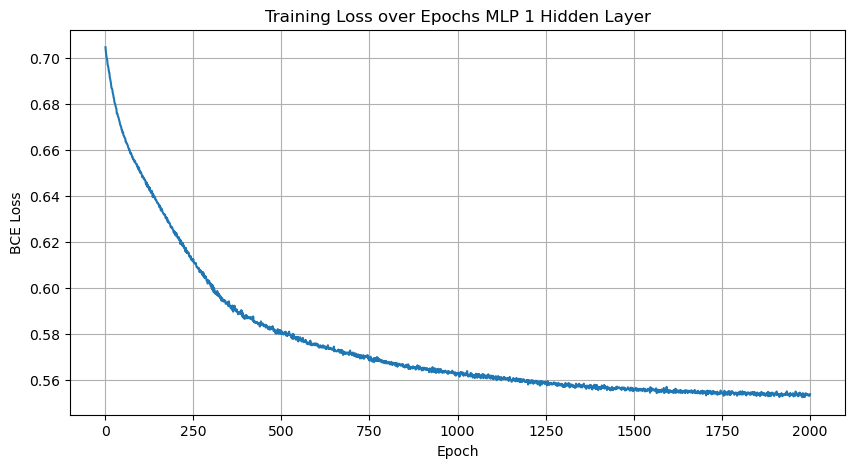

In [11]:
# Test set
y_pred = model(X_test_tensor).squeeze()

# Probabilities to class labels and threshold of 0.5 (> 0.5 = 1 (quark))
y_pred_class = (y_pred > 0.5).int() # .int() - converts True -> 1 and False -> 0 (1 and 0 (boolean output) from y_pred > 0.5)

# Convert to NumPy
y_pred_class = y_pred_class.detach().numpy()
y_test_numpy = y_test_tensor.detach().numpy()

# Statistics
print("Acuracy:", accuracy_score(y_test_numpy, y_pred_class))
print("Cinfusion Matrix:\n", confusion_matrix(y_test_numpy, y_pred_class))
print("Classification Report:\n", classification_report(y_test_numpy, y_pred_class))


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Training Loss over Epochs MLP 1 Hidden Layer")
plt.grid(True)

In [12]:
# 2 layer

# MLP - Multilayer Perceptron

torch.manual_seed(42)

# Converting NumPy data to torch Tensors
# Train
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Test
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


class MLP_2Hidden(nn.Module):
    def __init__(self):
        super(MLP_2Hidden, self).__init__()

        # Fully connected Input layer -> Hidden layer 1
        self.fc1 = nn.Linear(5, 16)

        # Droupout
        self.dropout = nn.Dropout(p=0.3)

        # Fully connected Hidden layer 1 -> Hidden layer 2
        self.fc2 = nn.Linear(16, 8)

        # Fully connected Hidden layer -> Output layer
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        # First layer - ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Hidden layer 2 - ReLU activation
        x = F.relu(self.fc2(x))

        # Output layer - sigmoid activation
        x = torch.sigmoid(self.fc3(x))

        return x

model = MLP_2Hidden()

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
epochs = 2000 
train_losses = []

for epoch in range(epochs):
    model.train()

    # Forward pass
    y_pred = model(X_train_tensor).squeeze() # squeeze removes extra dimension of size 1 (say, 2D to 1D array: [N,1] -> [N]).

    # Loss
    loss = loss_fn(y_pred, y_train_tensor)

    # Backpropagation
    optimizer.zero_grad() # clear gradients
    loss.backward()       # calculating gradient
    optimizer.step()      # updating weights

    train_losses.append(loss.item())  # Tracking loss for every epoch

    
    if (epoch+1) % 100 == 0:
        with torch.no_grad():  # Don't track gradients
            y_pred_train_class = (y_pred > 0.5).int()
            # y_pred_train_class = torch.round(y_pred).int()
            y_train_np = y_train_tensor.detach().numpy()
            y_pred_train_np = y_pred_train_class.detach().numpy()
            train_acc = accuracy_score(y_train_np, y_pred_train_np)
            # print(f"Epoch {epoch+1}/{epochs}, BCE Loss: {loss.item():.4f}")

print(y_pred[:5], y_test_tensor[:5])
print(model.fc1.weight, model.fc2.weight)


tensor([0.2414, 0.8134, 0.7841, 0.3524, 0.5821], grad_fn=<SliceBackward0>) tensor([0., 0., 1., 0., 0.])
Parameter containing:
tensor([[ 1.1327e-02,  1.3292e-01, -8.8217e-01,  1.1279e-02,  3.1080e-06],
        [-7.4020e-03, -1.0277e+00, -9.7704e-04,  2.7951e-01, -1.1812e-02],
        [ 1.3232e-02,  1.8877e-02,  6.1484e-01, -1.3684e-01,  1.4935e-02],
        [-1.8427e-02,  1.2631e-01,  6.8936e-01, -3.1583e-01,  2.1204e-01],
        [-2.2516e-02, -2.3529e-01, -6.5074e-01,  3.5337e-01, -3.8087e-02],
        [-4.8048e-03, -6.6350e-01, -6.0418e-01,  6.4504e-02,  1.6960e-02],
        [ 3.9096e-02,  3.2143e-02,  8.0589e-01, -1.3617e-01, -7.4424e-03],
        [ 2.3874e-02,  7.4793e-02,  5.8880e-01, -1.3571e-01, -3.4319e-03],
        [ 6.2624e-03, -2.3695e-01, -2.2612e-01,  7.6976e-01, -2.8079e-01],
        [-3.1307e-02,  4.8033e-02,  5.8594e-01, -1.4435e-01,  4.6668e-02],
        [-9.1774e-03, -5.9407e-01, -6.6360e-01,  2.2709e-01, -1.4466e-02],
        [ 5.6496e-02, -2.7340e-01, -2.5833e-01,  

Acuracy: 0.72255
Cinfusion Matrix:
 [[8065 1900]
 [3649 6386]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.81      0.74      9965
         1.0       0.77      0.64      0.70     10035

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000



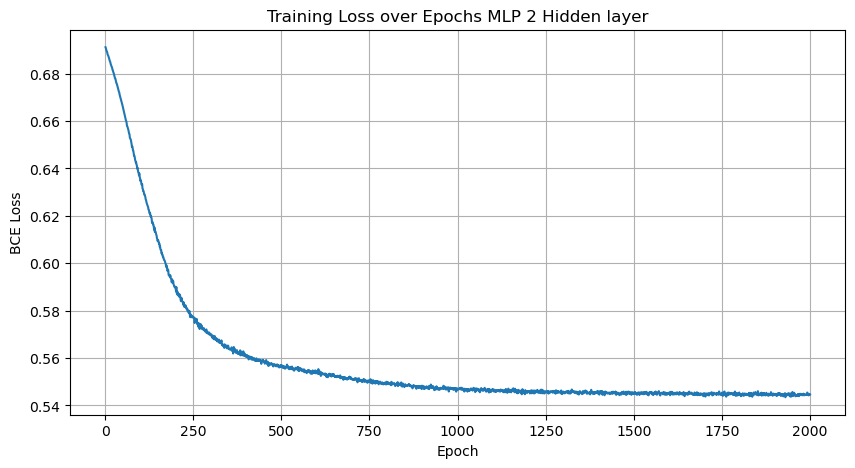

In [13]:
# Test set
y_pred = model(X_test_tensor).squeeze()

# Probabilities to class labels and threshold of 0.5 (> 0.5 = 1 (quark))
y_pred_class = (y_pred > 0.5).int() # .int() - converts True -> 1 and False -> 0 (1 and 0 (boolean output) from y_pred > 0.5)

# Convert to NumPy
y_pred_class = y_pred_class.detach().numpy()
y_test_numpy = y_test_tensor.detach().numpy()

# Statistics
print("Acuracy:", accuracy_score(y_test_numpy, y_pred_class))
print("Cinfusion Matrix:\n", confusion_matrix(y_test_numpy, y_pred_class))
print("Classification Report:\n", classification_report(y_test_numpy, y_pred_class))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Training Loss over Epochs MLP 2 Hidden layer")
plt.grid(True)
plt.show()

## Summary: Classical ML vs MLP on Quark-Gluon Classification

## Dataset
- Binary classification: Gluon (0) vs Quark (1)
- 5 features: `pt`, `eta`, `phi`, `eta_width`, `phi_width`

---

## Model Performances (on Test Set)

| Model                | Accuracy | F1-Score (Class 0 - Gluon) | F1-Score (Class 1 - Quark) |
|----------------------|----------|----------------------------|-----------------------------|
| Logistic Regression  | ~68.6%   | ~0.68                      | ~0.69                       |
| Random Forest (best) | ~72.65%  | ~0.75                      | **~0.70**                   |
| MLP (1 hidden layer) | ~71.80%  | ~0.75                      | ~0.68                       |
| MLP (2 hidden layers)| ~72.25%  | ~0.74                      | **~0.70**                   |

---

## Observations

- **MLP improves with depth**: Adding a second hidden layer increased performance slightly.
- **Random Forest remains strongest**, particularly in **quark recall** (fewer false negatives).
- **Neural networks still catching up**, but closing the gap fast.
- **Sigmoid output** gives class probabilities. We used a **0.5 threshold** to map to 0/1.

---

## Implementation Notes

- Optimizer: Adam
- Loss Function: Binary Cross-Entropy
- Regularization: Dropout + Weight Decay
- Trained for 2000 epochs
- Inputs scaled with `RobustScaler`

---

## Next Steps

1. **Batch Training**
   - Switch from full-batch to mini-batch training
   - More realistic & memory efficient

2. **Loss Curve Visualization**
   - Plot BCE loss over epochs
   - Monitor convergence & spot overfitting

3. **Bayesian Neural Network (BNN)**
   - Introduce uncertainty into weights
   - Essential for Uncertainty Quantification

---





In [14]:
from torch.utils.data import TensorDataset, DataLoader

# Using MLP_2Hidden architecture
class MLP_2Hidden(nn.Module):
    def __init__(self):
        super(MLP_2Hidden, self).__init__()

        # Fully connected Input layer -> Hidden layer 1
        self.fc1 = nn.Linear(5, 16)

        # Droupout
        self.dropout = nn.Dropout(p=0.3)

        # Fully connected Hidden layer 1 -> Hidden layer 2
        self.fc2 = nn.Linear(16, 8)

        # Fully connected Hidden layer -> Output layer
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        # First layer - ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Hidden layer 2 - ReLU activation
        x = F.relu(self.fc2(x))

        # Output layer - sigmoid activation
        x = torch.sigmoid(self.fc3(x))

        return x


batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


model = MLP_2Hidden()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 2000
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0  # Accumulate loss for averaging

    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model(X_batch).squeeze()

        # Loss
        loss = loss_fn(y_pred, y_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Avg. Loss: {avg_loss:.4f}")
        
        
        


Epoch 100/2000, Avg. Loss: 0.5427
Epoch 200/2000, Avg. Loss: 0.5425
Epoch 300/2000, Avg. Loss: 0.5414
Epoch 400/2000, Avg. Loss: 0.5410
Epoch 500/2000, Avg. Loss: 0.5412
Epoch 600/2000, Avg. Loss: 0.5414
Epoch 700/2000, Avg. Loss: 0.5409
Epoch 800/2000, Avg. Loss: 0.5416
Epoch 900/2000, Avg. Loss: 0.5415
Epoch 1000/2000, Avg. Loss: 0.5409
Epoch 1100/2000, Avg. Loss: 0.5411
Epoch 1200/2000, Avg. Loss: 0.5412
Epoch 1300/2000, Avg. Loss: 0.5411
Epoch 1400/2000, Avg. Loss: 0.5414
Epoch 1500/2000, Avg. Loss: 0.5412
Epoch 1600/2000, Avg. Loss: 0.5413
Epoch 1700/2000, Avg. Loss: 0.5411
Epoch 1800/2000, Avg. Loss: 0.5411
Epoch 1900/2000, Avg. Loss: 0.5410
Epoch 2000/2000, Avg. Loss: 0.5411


Acuracy: 0.72345
Cinfusion Matrix:
 [[7905 2060]
 [3471 6564]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.79      0.74      9965
         1.0       0.76      0.65      0.70     10035

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000



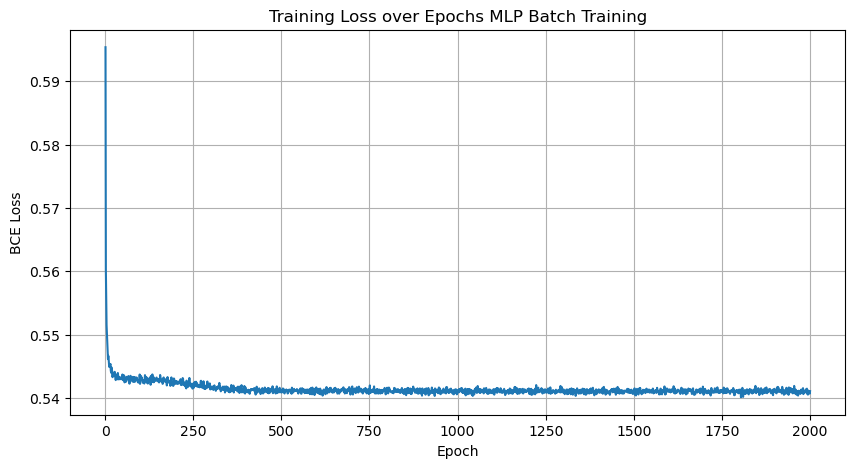

In [15]:
# Test set
y_pred = model(X_test_tensor).squeeze()

# Probabilities to class labels and threshold of 0.5 (> 0.5 = 1 (quark))
y_pred_class = (y_pred > 0.5).int() # .int() - converts True -> 1 and False -> 0 (1 and 0 (boolean output) from y_pred > 0.5)

# Convert to NumPy
y_pred_class = y_pred_class.detach().numpy()
y_test_numpy = y_test_tensor.detach().numpy()

# Statistics
print("Acuracy:", accuracy_score(y_test_numpy, y_pred_class))
print("Cinfusion Matrix:\n", confusion_matrix(y_test_numpy, y_pred_class))
print("Classification Report:\n", classification_report(y_test_numpy, y_pred_class))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Training Loss over Epochs MLP Batch Training")
plt.grid(True)
plt.show()

##  MLP Results Summary: Binary Classification (Quark vs Gluon)

| Model           | Architecture     | Training Type | Accuracy | Notes                      |
|----------------|------------------|----------------|----------|----------------------------|
| Logistic Reg.  | –                | –              | ~66%     | Baseline                   |
| Random Forest  | –                | GridSearch     | **~72.65%** | Best traditional ML        |
| MLP            | 1 Hidden Layer   | Full-batch     | ~71.8%   | Stable improvement         |
| MLP            | 2 Hidden Layers  | Full-batch     | ~72.2%   | Slightly better            |
| MLP            | 2 Hidden Layers  | **Mini-batch** | **~72.34%** | Best DL model so far       |

---

### Observations
- **Random Forest** remains the best overall, likely due to:
  - Strong performance on tabular data
  - Inherent ensembling (bootstrapped trees)
- **MLPs showed competitive performance**, and improved with:
  - Deeper architecture (2 layers)
  - Regularization (dropout, weight decay)
  - Mini-batch training

### Why did we not beat Random Forest Classifier?
- **Data Size**: 80K may still be too small for NN to truly shine
- **Feature Simplicity**: Engineered features (like $η$-width, $p_T$) may favor decision trees
- **No deep signal complexity**: If the features are linearly or hierarchically separable, RF excels


---



# Bayesian Neural Networks

In [16]:
# BNN_MLP using MC Dropout

torch.manual_seed(42)


class BnnMCDropout(nn.Module):
    def __init__(self):
        super(BnnMCDropout, self).__init__()
        self.fc1 = nn.Linear(5, 16)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Dropout again at second hidden layer
        x = torch.sigmoid(self.fc3(x))
        return x

# Instantiate model, loss, optimizer
model = BnnMCDropout()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
epochs = 2000
train_losses = []
batch_size = 512

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader:
        # Forward pass
        y_pred = model(batch_X).squeeze()
        loss = loss_fn(y_pred, batch_y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Avg. Loss: {avg_loss:.4f}")

Epoch 100/2000, Avg. Loss: 0.5562
Epoch 200/2000, Avg. Loss: 0.5577
Epoch 300/2000, Avg. Loss: 0.5557
Epoch 400/2000, Avg. Loss: 0.5566
Epoch 500/2000, Avg. Loss: 0.5579
Epoch 600/2000, Avg. Loss: 0.5574
Epoch 700/2000, Avg. Loss: 0.5567
Epoch 800/2000, Avg. Loss: 0.5578
Epoch 900/2000, Avg. Loss: 0.5584
Epoch 1000/2000, Avg. Loss: 0.5574
Epoch 1100/2000, Avg. Loss: 0.5577
Epoch 1200/2000, Avg. Loss: 0.5575
Epoch 1300/2000, Avg. Loss: 0.5575
Epoch 1400/2000, Avg. Loss: 0.5570
Epoch 1500/2000, Avg. Loss: 0.5570
Epoch 1600/2000, Avg. Loss: 0.5578
Epoch 1700/2000, Avg. Loss: 0.5583
Epoch 1800/2000, Avg. Loss: 0.5572
Epoch 1900/2000, Avg. Loss: 0.5574
Epoch 2000/2000, Avg. Loss: 0.5578


Acuracy: 0.7192
Cinfusion Matrix:
 [[8116 1849]
 [3767 6268]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.81      0.74      9965
         1.0       0.77      0.62      0.69     10035

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000



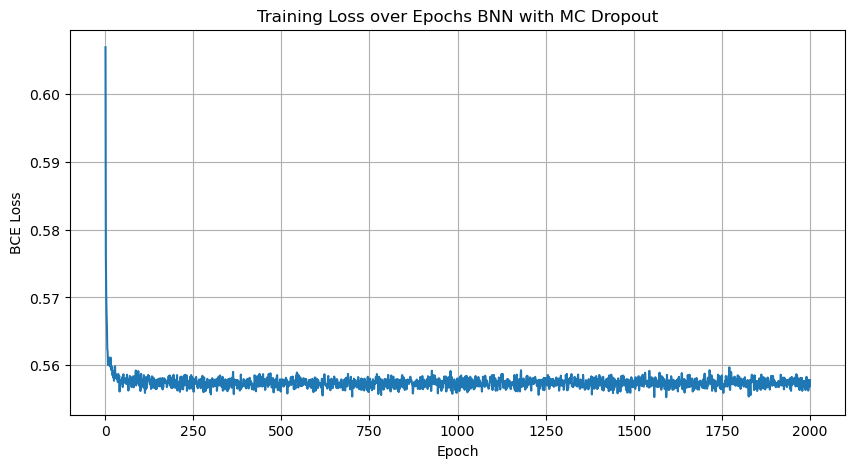

In [17]:
# Test set
y_pred = model(X_test_tensor).squeeze()

# Probabilities to class labels and threshold of 0.5 (> 0.5 = 1 (quark))
y_pred_class = (y_pred > 0.5).int() # .int() - converts True -> 1 and False -> 0 (1 and 0 (boolean output) from y_pred > 0.5)

# Convert to NumPy
y_pred_class = y_pred_class.detach().numpy()
y_test_numpy = y_test_tensor.detach().numpy()

# Statistics
print("Acuracy:", accuracy_score(y_test_numpy, y_pred_class))
print("Cinfusion Matrix:\n", confusion_matrix(y_test_numpy, y_pred_class))
print("Classification Report:\n", classification_report(y_test_numpy, y_pred_class))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Training Loss over Epochs BNN with MC Dropout")
plt.grid(True)
plt.show()

Accuracy: 0.7253
Confusion Matrix:
 [[8121 1844]
 [3650 6385]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.81      0.75      9965
         1.0       0.78      0.64      0.70     10035

    accuracy                           0.73     20000
   macro avg       0.73      0.73      0.72     20000
weighted avg       0.73      0.73      0.72     20000

Average Uncertainty: 0.07389203
Average Confidence: 0.926108
% of predictions with >90% confidence: 91.27499999999999


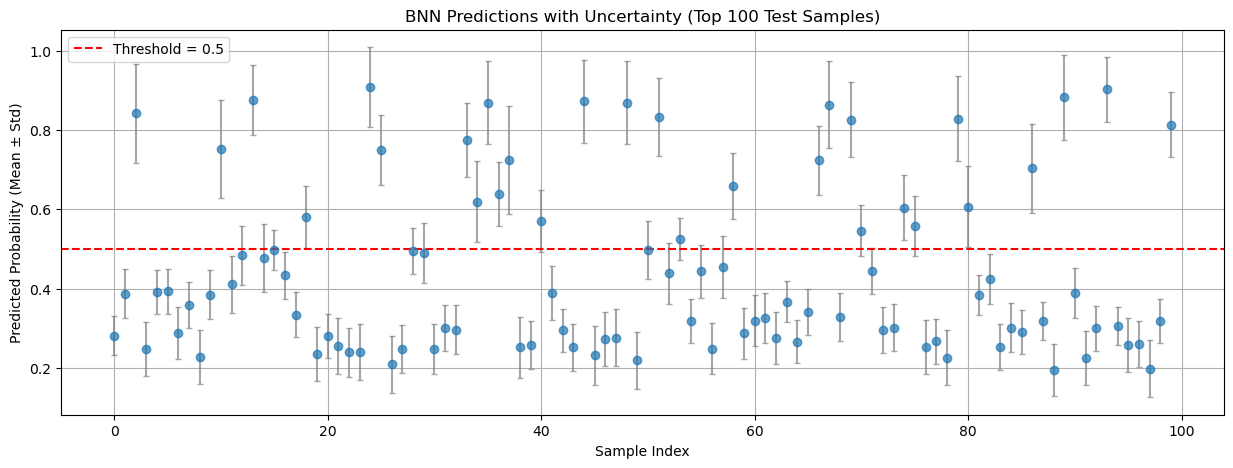

In [18]:
# Monte Carlo Inference for BNN with MC Dropout

# Function to perform MC Dropout Inference
def mc_dropout_predict(model, X_tensor, n_samples=100):
    model.train()  # Important: dropout must be ON during inference for MC sampling
    preds = []

    with torch.no_grad():
        for _ in range(n_samples):
            pred = model(X_tensor).squeeze()
            preds.append(pred.cpu().numpy())

    preds = np.array(preds)  # shape: [n_samples, N]
    mean_preds = preds.mean(axis=0)
    std_preds = preds.std(axis=0)
    return mean_preds, std_preds

# Perform MC Inference
mean_probs, std_probs = mc_dropout_predict(model, X_test_tensor, n_samples=100)

# Convert ground truth
true_labels = y_test_tensor.detach().cpu().numpy()

# Classification based on mean probabilities
predicted_classes = (mean_probs > 0.5).astype(int)

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(true_labels, predicted_classes))
print("Confusion Matrix:\n", confusion_matrix(true_labels, predicted_classes))
print("Classification Report:\n", classification_report(true_labels, predicted_classes))
# print("Mean Probability:", mean_probs[:10])
# print("Uncertainty:", std_probs[:10])
# print("Confidence score:", 1 - std_probs[:10])


overall_uncertainty = std_probs.mean()
print("Average Uncertainty:", overall_uncertainty)

average_confidence = (1 - std_probs).mean()
print("Average Confidence:", average_confidence)

threshold = 0.9
percent_high_conf = np.mean((1 - std_probs) > threshold) * 100
print(f"% of predictions with >{threshold*100:.0f}% confidence:", percent_high_conf)


# Visualization: Mean ± Std Dev for first 100 samples
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.errorbar(range(100), mean_probs[:100], yerr=std_probs[:100], fmt='o', ecolor='gray', alpha=0.7, capsize=2)
plt.axhline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title("BNN Predictions with Uncertainty (Top 100 Test Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability (Mean ± Std)")
plt.legend()
plt.grid(True)
plt.show()


### Bayesian Neural Network (BNN) Summary

| Model           | Architecture       | Training Type | Accuracy | Avg. Confidence | % >90% Conf | Notes                                 |
|----------------|--------------------|----------------|----------|------------------|---------------|---------------------------------------|
| Logistic Reg.  | –                  | –              | ~66%     | –                | –             | Baseline                              |
| Random Forest  | –                  | GridSearch     | **~72.65%** | –                | –             | Best traditional ML                   |
| MLP            | 1 Hidden Layer     | Full-batch     | ~71.8%   | –                | –             | Stable improvement                    |
| MLP            | 2 Hidden Layers    | Full-batch     | ~72.2%   | –                | –             | Slightly better                       |
| MLP            | 2 Hidden Layers    | **Mini-batch** | **~72.34%** | –                | –             | Best DL model so far                  |
| **BNN (MC Dropout)** | 2 Hidden Layers w/ Dropout x2 | Mini-batch     | **~72.54%** | **92.6%**         | **91.07%**      | First Uncertainty-Aware Model (MC Dropout)

---

**Summary**: 
BNN using Monte Carlo Dropout achieved an accuracy of **72.54%**, with an **average confidence score of 92.6%** and **91.07% of predictions above 90% confidence**. This not only matches the performance of traditional MLPs, but adds a layer of uncertainty quantification, making the model interpretable and reliable under ambiguity.

**Inference Quality**:
- Predictions are accompanied by **mean ± std deviation** (visualized for top 100 samples).
- The model is both **accurate** and **self-aware** — knowing when it’s confident vs. uncertain.